<a id='Table_Contents'></a>
<h2 style="background-color:#fbcc54;font-family:monospace;font-size:150%;text-align:center">Table of Contents</h2>

<a id='Problem_Definition'></a>
<h2 style="background-color:#fbcc54;font-family:monospace;font-size:150%;text-align:center">1.Problem Definition</h2>

The goal is to build a model to predict whether a borrower (new customer) is going to
default by learning from this pool of borrowers’ behavior.

<a id='Approach'></a>
<h2 style="background-color:#fbcc54;font-family:monospace;font-size:150%;text-align:center">2. Approach</h2>

Build a binary classification model based on a simulated dataset, performing 
- data cleaning, handling missing values, and exploratory analysis, 
- Feature engineering and selection, 
- Model selection, training and evalution,

<a id='Data'></a>
<h2 style="background-color:#fbcc54;font-family:monospace;font-size:150%;text-align:center">3.Data</h2>

In [1]:
import pandas as pd
import requests
import io
import seaborn as sns
import math    
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import phik
from phik import resources, report
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.metrics import make_scorer, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    auc,
    roc_curve,
    f1_score,
    accuracy_score,
    classification_report,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve
)
from xgboost import XGBClassifier
from rfpimp import permutation_importances
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
import shap
# for Q-Q plots
import scipy.stats as stats
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
raw = pd.read_csv('Data.csv')
raw.head()

,id,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,...,last_credit_pull_d,last_fico_range_high,last_fico_range_low,acc_now_delinq,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,inq_last_6mths,inq_last_12m
0,88787390,30000,60 months,761.64,6 years,RENT,100100.0,Verified,Sep-16,Current,...,Dec-16,709,705,0,0,0,26.0,NaN,0,0.0
1,74722660,30000,60 months,692.93,10+ years,MORTGAGE,235000.0,Source Verified,Apr-16,Current,...,Dec-16,649,645,0,0,1,16.0,NaN,1,3.0
2,67919555,16000,60 months,379.39,6 years,RENT,84000.0,Not Verified,Jan-16,Current,...,Dec-16,739,735,0,0,0,80.0,NaN,0,2.0
3,54027458,14000,36 months,439.88,5 years,RENT,50000.0,Source Verified,Jul-15,Fully Paid,...,Oct-16,749,745,0,0,0,NaN,42.0,0,NaN
4,72594974,7500,36 months,252.67,3 years,MORTGAGE,68000.0,Not Verified,Feb-16,Fully Paid,...,Dec-16,709,705,0,0,0,NaN,NaN,2,5.0


### target variable

Dependent variable꞉ a new variable 'default' generated from 'loan_status'. If 'loan_status' is default (fail to pay), then the new variable 'default' is 1, else 0.


In [3]:
raw['y'] = raw['loan_status'].apply(lambda x: 0 if x in ['Current', 'Fully Paid'] else 1)
raw.drop(['loan_status'], axis=1, inplace=True)

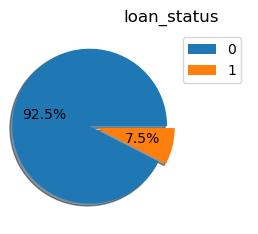

In [4]:
fig = raw['y'].value_counts().plot(kind="pie", autopct='%1.1f%%',
                                shadow=True, explode=[0.05, 0.05], 
                                legend=True,  ylabel='', labeldistance=None, 
                                figsize=(2, 3))
fig.set_xlim(0, 2)
fig.set_title('loan_status')
plt.show()

In [5]:
# let's inspect the variable values

for var in raw.columns:
    print(var, raw[var].unique()[0:20], '\n')

id [88787390 74722660 67919555 54027458 72594974 74815224 71061534 54474095
 73293041 83809734 74904435 46745040 77428512 39519608 74643492 51376993
 55999180 70181590 88870882 61384205] 

loan_amnt [30000 16000 14000  7500  2800 25000 12000  6400  5000  9000 21000 11200
 16500 32325  8000 35000 24000 20000 10000  9500] 

term ['60 months' '36 months'] 

installment [ 761.64  692.93  379.39  439.88  252.67   94.33  870.44  382.55  204.
  233.61  160.75  326.51  685.03  302.94  318.48 1000.59  369.93  418.73
  512.46 1066.42] 

emp_length ['6 years' '10+ years' '5 years' '3 years' '< 1 year' nan '7 years'
 '8 years' '2 years' '1 year' '4 years' '9 years'] 

home_ownership ['RENT' 'MORTGAGE' 'OWN' 'ANY'] 

annual_inc [100100.  235000.   84000.   50000.   68000.   25000.   55000.   30000.
  35000.   72000.   95000.  150000.   34714.8  72300.  110000.  120000.
  49000.  170000.   29000.   90000. ] 

verification_status ['Verified' 'Source Verified' 'Not Verified'] 

issue_d ['Sep-16' 'Apr-

In [6]:
# make list of variables  types

# numerical: discrete vs continuous
discrete_num = [var for var in raw.columns if raw[var].dtype!='O' and var!='y' and raw[var].nunique()<10]
continuous_num = [var for var in raw.columns if raw[var].dtype!='O' and var!='y' and var not in discrete_num]

# categorical
categorical = [var for var in raw.columns if raw[var].dtype=='O'and var!='y']

print('There are {} discrete numerical variables'.format(len(discrete_num)))
print('There are {} continuous numerical variables'.format(len(continuous_num)))
print('There are {} categorical variables'.format(len(categorical)))


There are 2 discrete numerical variables
There are 14 continuous numerical variables
There are 9 categorical variables


In [7]:
discrete_num

['acc_now_delinq', 'inq_last_6mths']

In [8]:
continuous_num

['id',
 'loan_amnt',
 'installment',
 'annual_inc',
 'dti',
 'fico_range_low',
 'fico_range_high',
 'last_fico_range_high',
 'last_fico_range_low',
 'delinq_amnt',
 'delinq_2yrs',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'inq_last_12m']

In [9]:
categorical

['term',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'last_credit_pull_d']

### Missing Values

Total 5 features have missing values.


<Axes: title={'center': 'Missing value percentage'}>

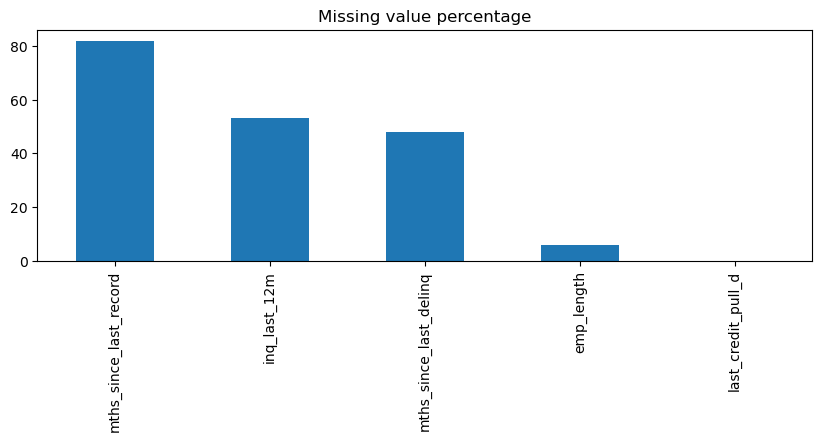

In [10]:

print(f"Total {sum(raw.isnull().mean()>0)} features have missing values.")
print('='*50)
(raw.isnull().mean()
            .nlargest(sum(raw.isnull().mean()>0))
            .mul(100)
            .plot(kind='bar', figsize=(10,3), 
                  title='Missing value percentage'))

In [11]:
raw['mths_since_last_record'].isnull().groupby(raw['y']).mean()

y
0    0.819788
1    0.800729
Name: mths_since_last_record, dtype: float64

In [12]:
raw['inq_last_12m'].isnull().groupby(raw['y']).mean()

y
0    0.516326
1    0.731489
Name: inq_last_12m, dtype: float64

In [13]:
raw['mths_since_last_delinq'].isnull().groupby(raw['y']).mean()

y
0    0.479510
1    0.455193
Name: mths_since_last_delinq, dtype: float64

In [14]:
raw['emp_length'].isnull().groupby(raw['y']).mean()

y
0    0.060206
1    0.068908
Name: emp_length, dtype: float64

In [15]:
raw['last_credit_pull_d'].isnull().groupby(raw['y']).mean()

y
0    0.000054
1    0.000000
Name: last_credit_pull_d, dtype: float64

We observe more missing data points for the defaulters in inq_last_12m. The other variable missing values are random.

### cardinality

In [16]:
for col in categorical:
    print('variable: ', col, ' number of labels: ', raw[col].nunique())

print('total clients: ', len(raw))

variable:  term  number of labels:  2
variable:  emp_length  number of labels:  11
variable:  home_ownership  number of labels:  4
variable:  verification_status  number of labels:  3
variable:  issue_d  number of labels:  21
variable:  purpose  number of labels:  13
variable:  addr_state  number of labels:  50
variable:  earliest_cr_line  number of labels:  629
variable:  last_credit_pull_d  number of labels:  25
total clients:  80000


earliest_cr_line, last_credit_pull_d, addr_state, issue_d contain a huge number of different labels (high cardinality).

### Rare Labels

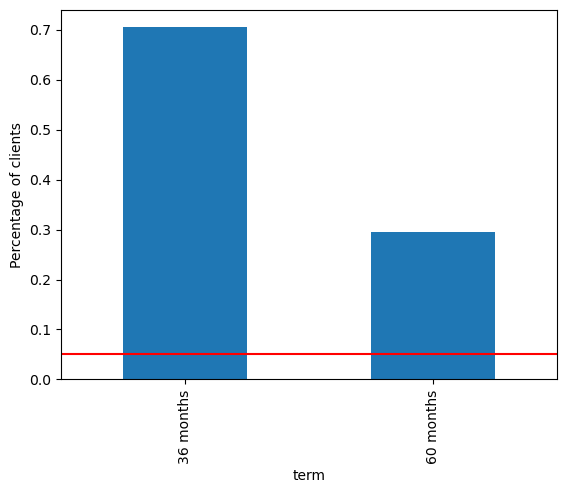

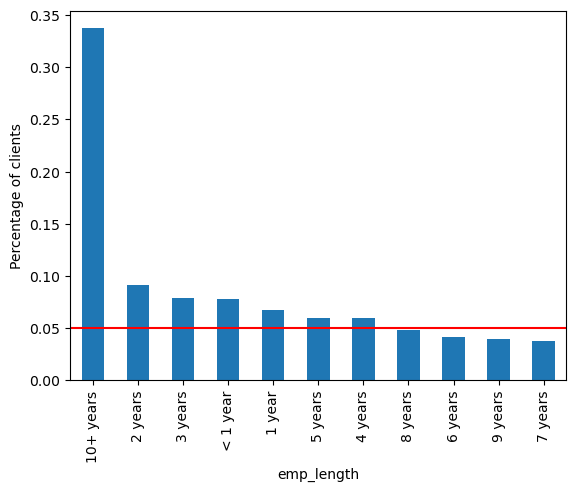

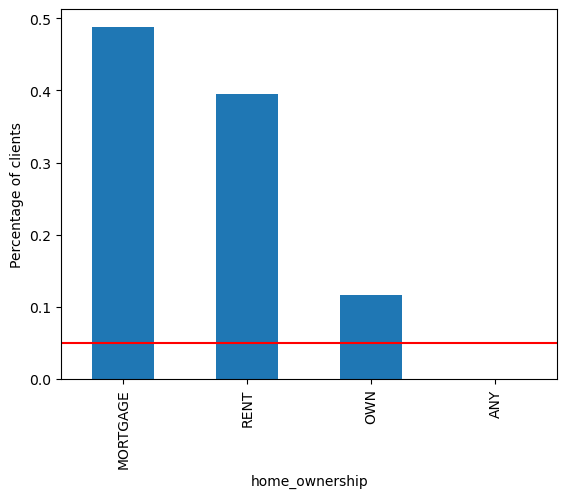

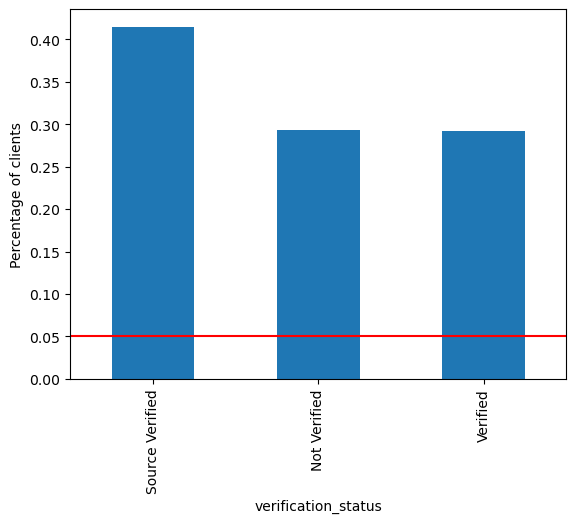

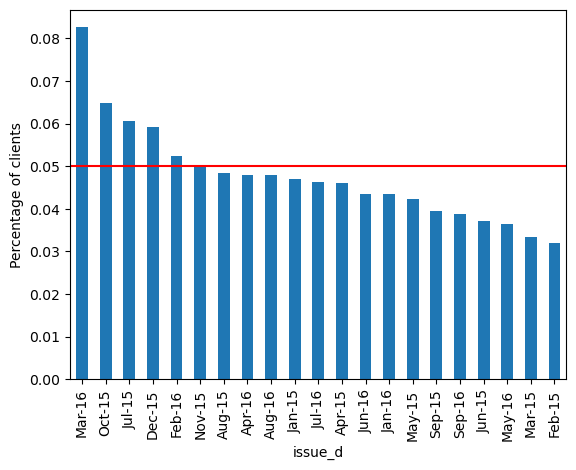

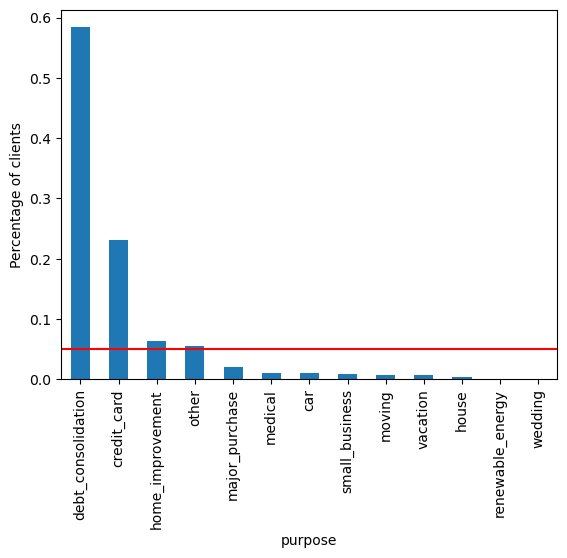

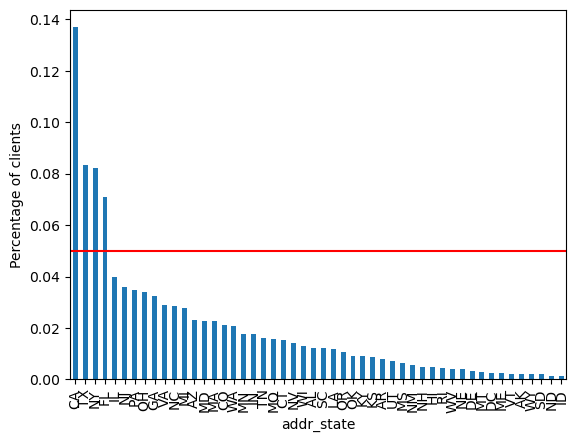

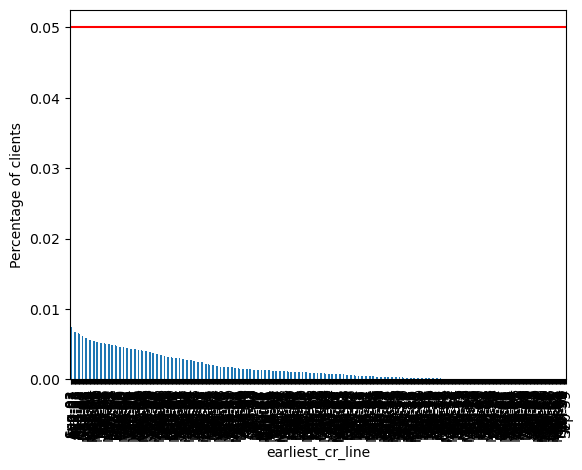

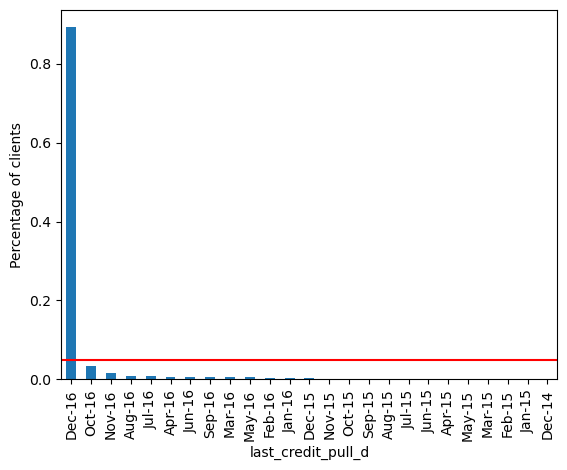

In [17]:
# Let's plot the category frequency.
# That is, the percentage of houses with each label.
# For each categorical variable
for col in categorical:

    # Count the number of houses per category
    # and divide by total houses.

    # That is, the percentage of houses per category.

    temp_df = pd.Series(raw[col].value_counts() / len(raw))

    # Make plot with these percentages.
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # Add a line at 5 % to flag the threshold for rare categories.
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of clients')
    plt.show()

### Outliers

In [18]:
# outliers
# Function to create a histogram, a Q-Q plot and
# a boxplot.

def diagnostic_plots(df, variable):
    # The function takes a dataframe (df) and
    # the variable of interest as arguments.

    # Define figure size.
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [19]:
# Function to find upper and lower boundaries
# for normally distributed variables.

def find_normal_boundaries(df, variable):

    # Calculate the boundaries
    # for a Gaussian distribution.

    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

In [20]:
# Assuming that annual_inc is normally distributed, 
# calculate boundaries for annual_inc.

upper_boundary, lower_boundary = find_normal_boundaries(raw, 'annual_inc')
upper_boundary, lower_boundary

(337250.15005320066, -181670.24440520062)

Values bigger than 337250 consider them outliers.

In [21]:
upper_boundary, lower_boundary = find_normal_boundaries(raw, 'dti')
upper_boundary, lower_boundary

(205.05995023144317, -166.16681423144314)

Values bigger than 205 consider them outliers.

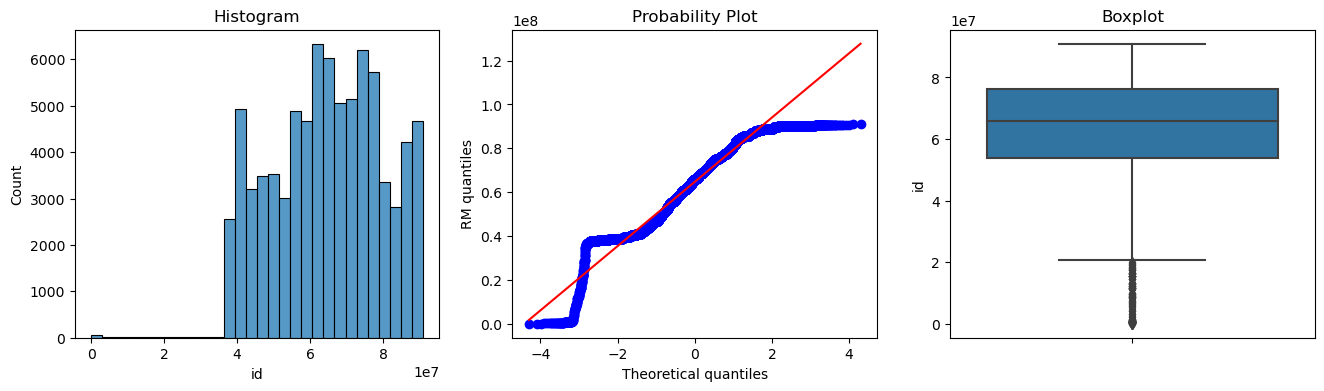

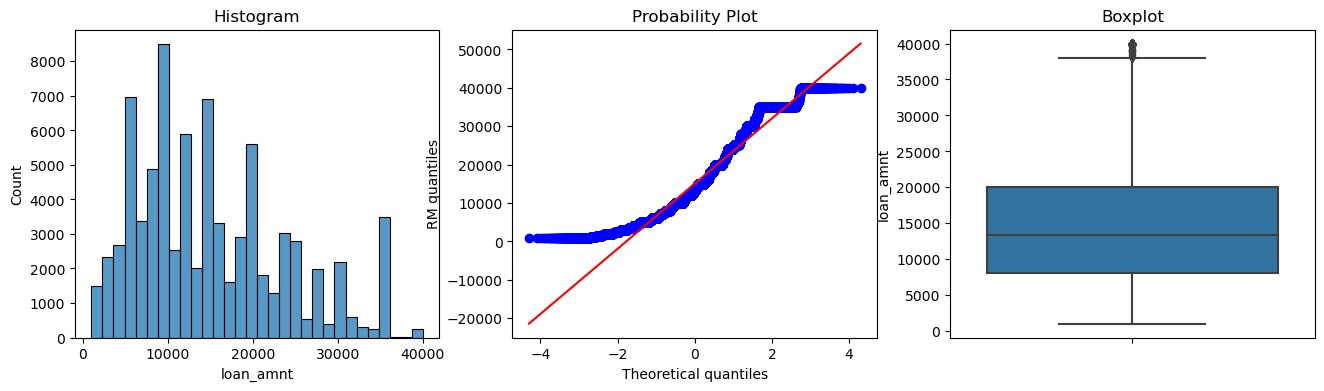

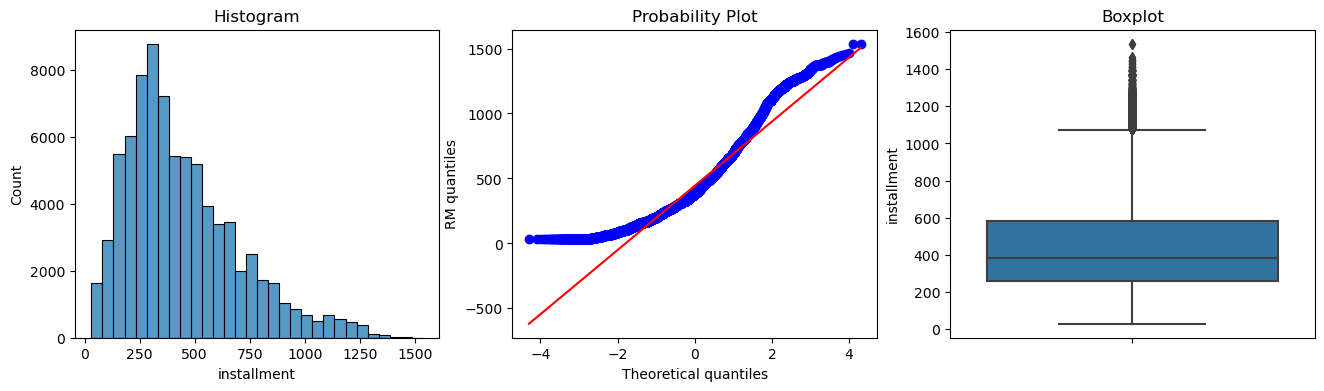

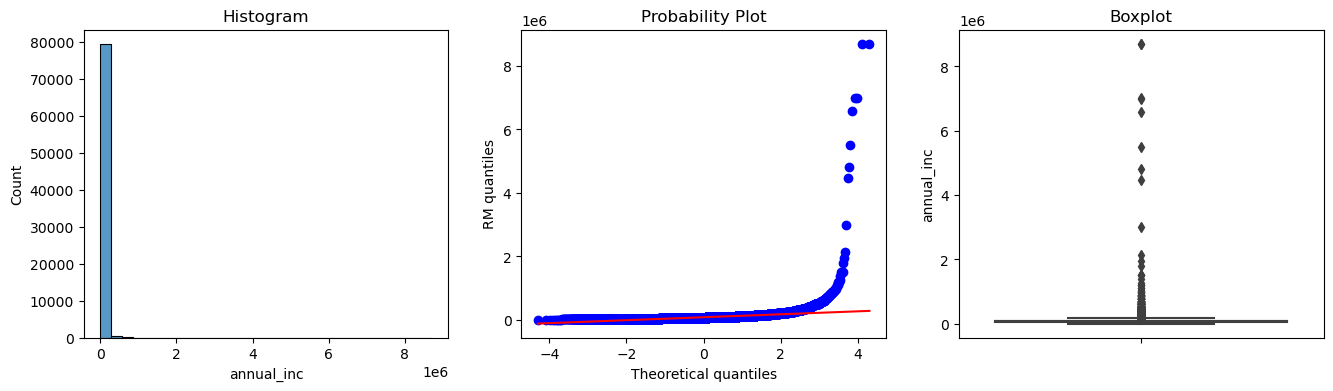

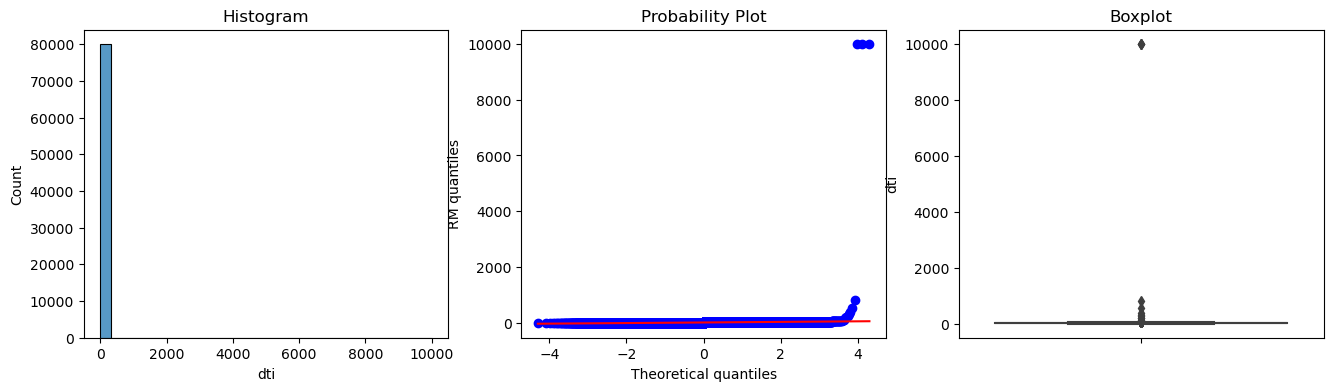

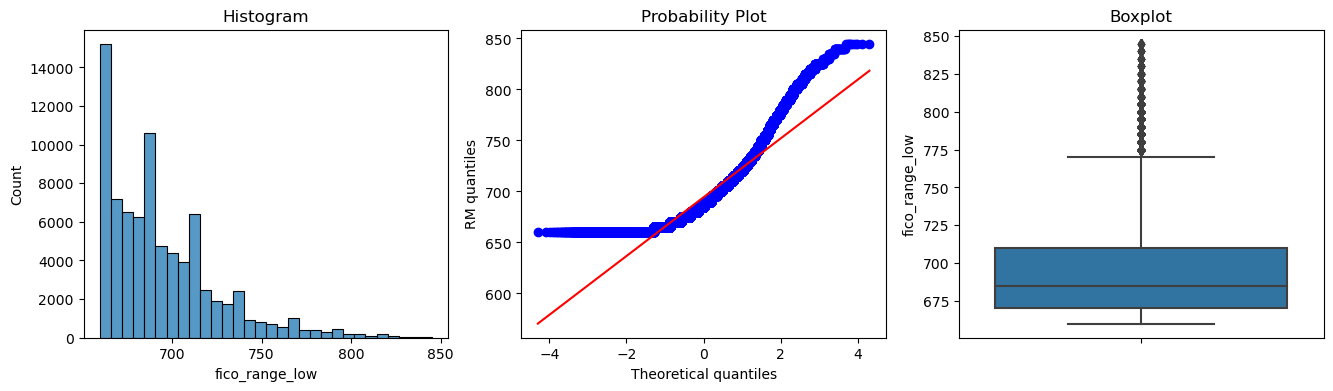

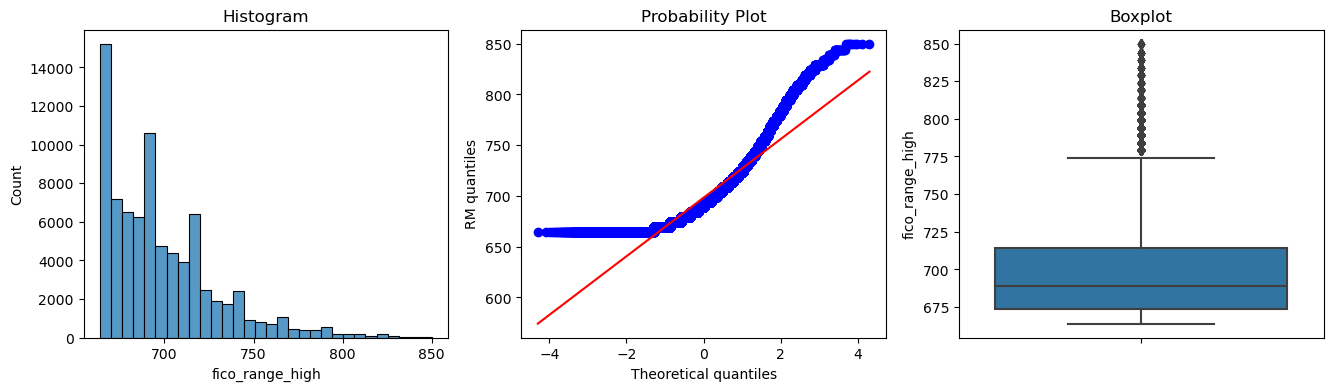

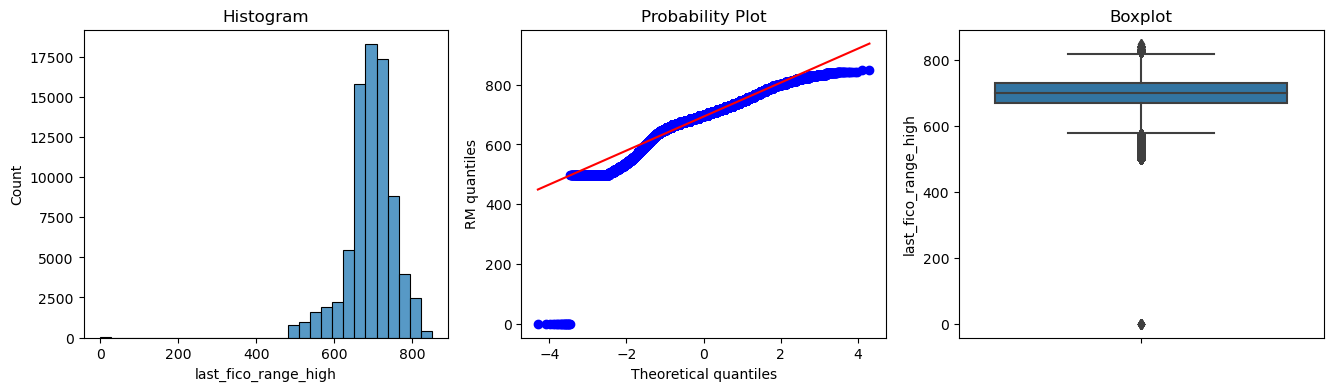

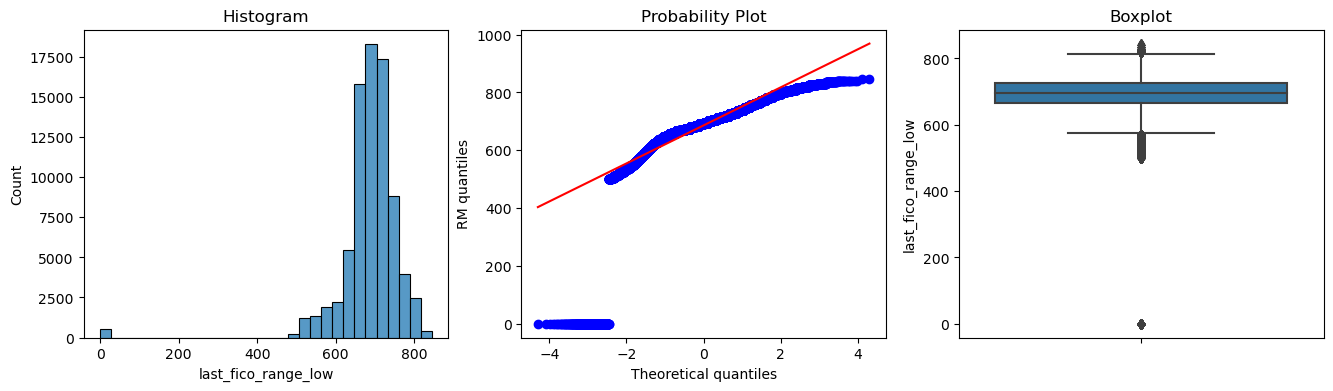

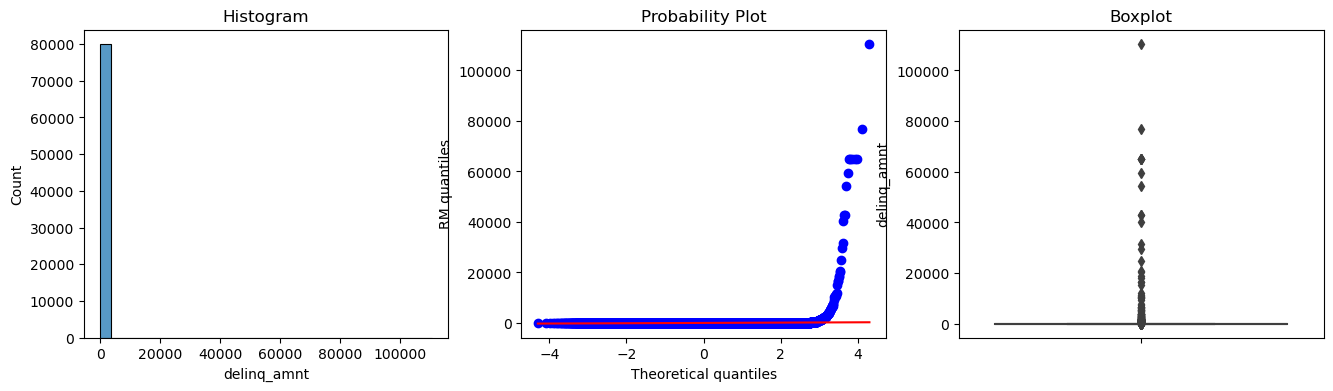

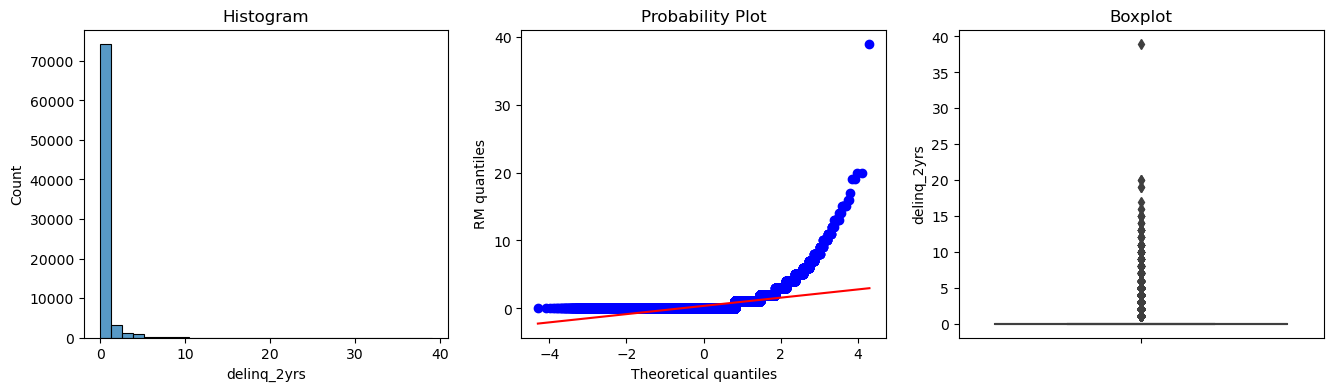

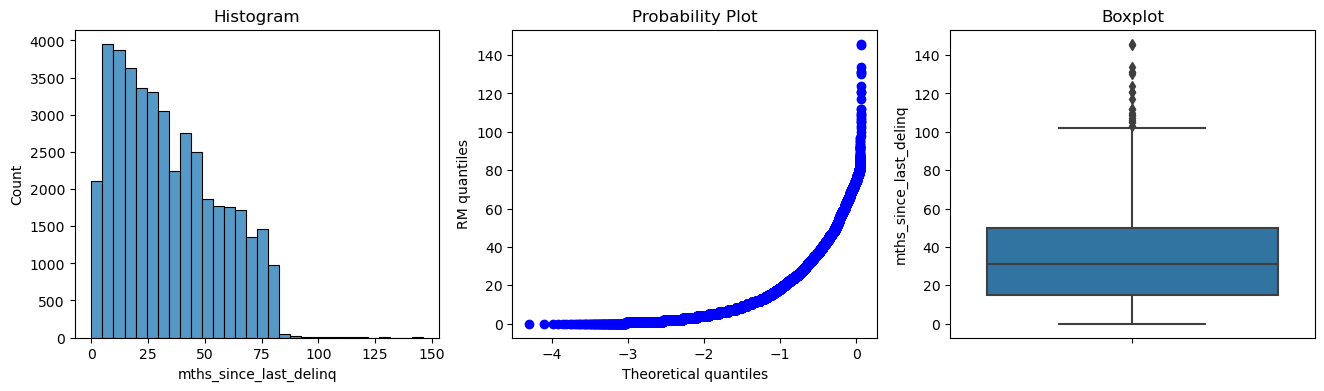

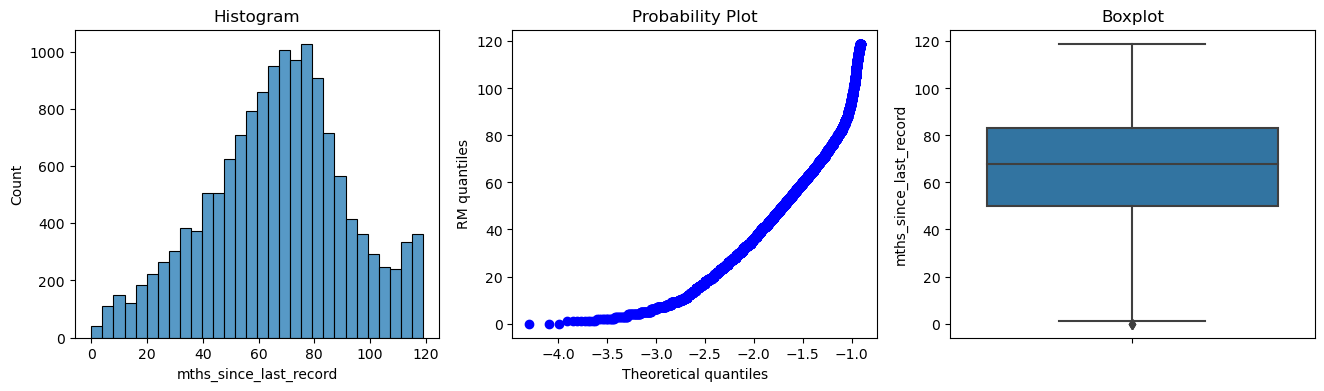

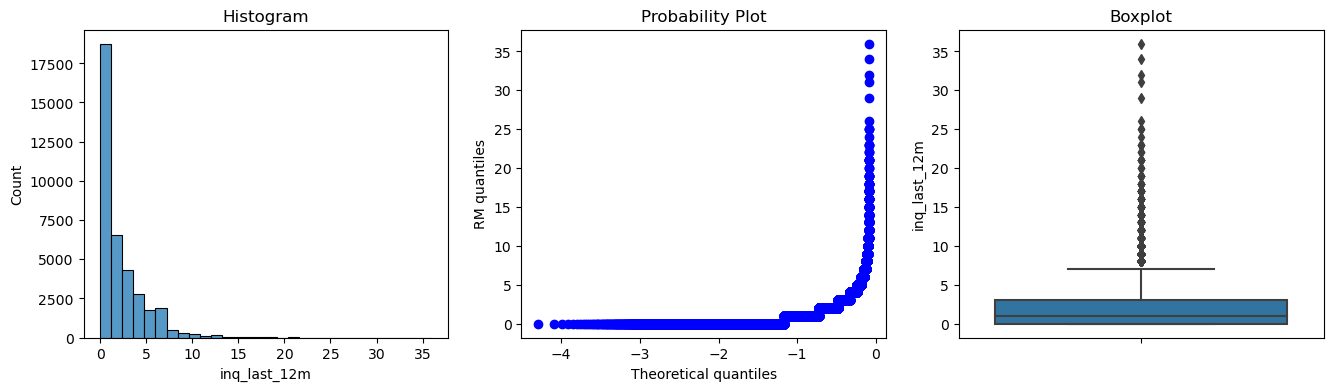

<Figure size 640x480 with 0 Axes>

In [22]:
# outliers

df = raw.loc[:,(continuous_num)]

for i, col in enumerate(continuous_num):
    diagnostic_plots(df, col)

plt.tight_layout();

In [23]:
# Function to find upper and lower boundaries
# for skewed variables.
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries
    # for skewed distributions

    # The parameter "distance" gives us the option to
    # estimate 1.5 times or 3 times the IQR when defining
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [24]:
# Find outliers with the IQR proximity rule.
# Here we use, IQR * 1.5, the standard metric.

upper_boundary, lower_boundary = find_skewed_boundaries(raw, 'delinq_amnt', 1.5)
upper_boundary, lower_boundary

(0.0, 0.0)

<a id='EDA'></a>
<h1 style="background-color:#fbcc54;font-family:monospace;font-size:200%;text-align:center">4. EDA </h1>

### Data preprocessing

### 1. Continuous numeric variables

### ID

In [25]:
raw['id'].nunique(), len(raw)

(80000, 80000)

In [26]:
#drop id
raw.drop(['id'], axis=1, inplace=True)

### FICO

In [27]:
raw['last_fico_average'] = (raw['last_fico_range_low'] + raw['last_fico_range_high']) / 2

In [28]:
raw['fico_average'] = (raw['fico_range_low'] + raw['fico_range_high']) / 2

In [29]:
raw.drop(['last_fico_range_low', 'last_fico_range_high', 'fico_range_low','fico_range_high'], axis=1, inplace=True)

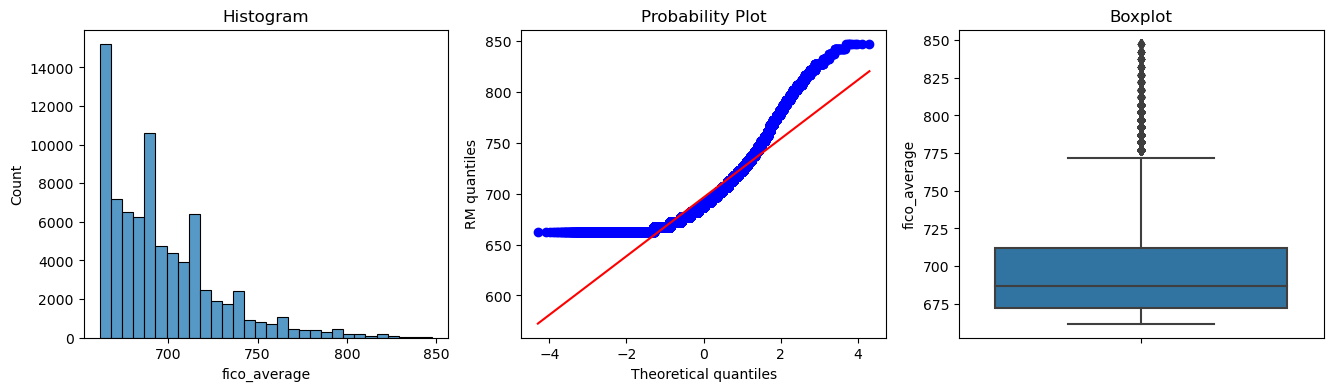

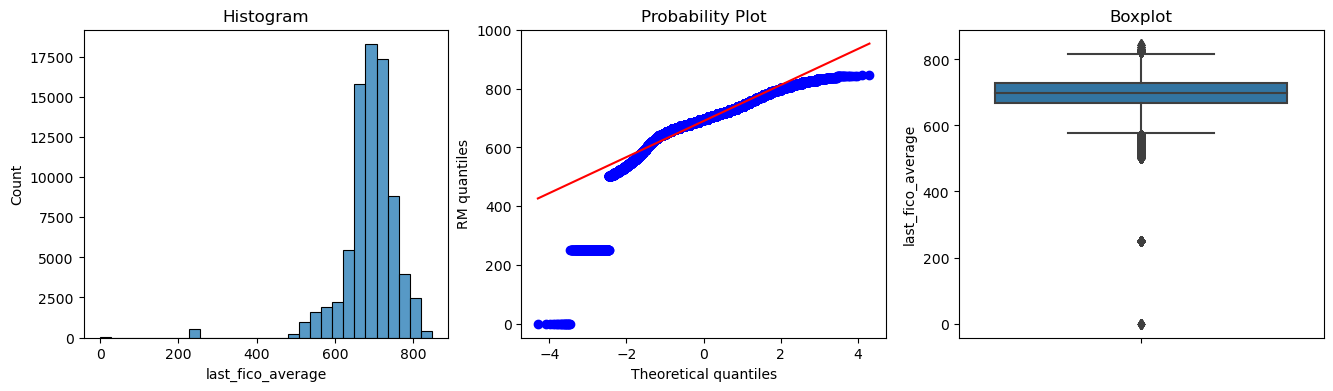

In [30]:
diagnostic_plots(raw, 'fico_average')
diagnostic_plots(raw, 'last_fico_average')

Text(0.5, 1.0, 'last_fico_average Distribution')

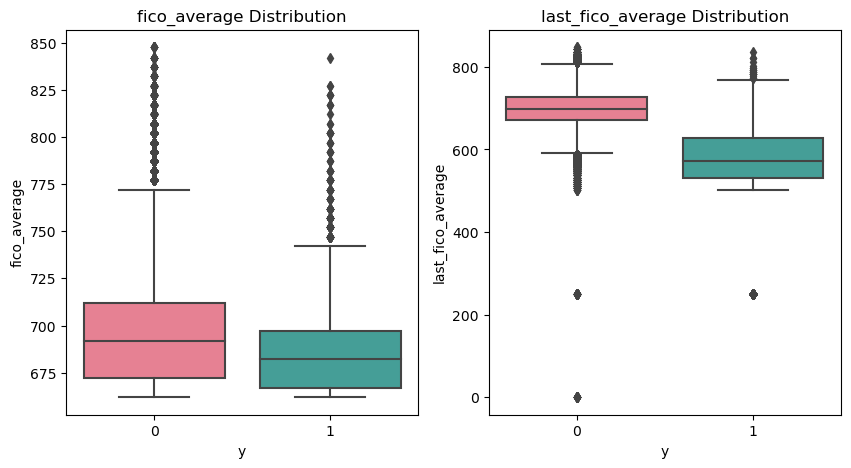

In [31]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plt.subplot(1,2,1)
sns.boxplot(x='y',y='fico_average', data=raw, palette = 'husl')
plt.title('fico_average Distribution')

plt.subplot(1,2,2)
sns.boxplot(x='y',y='last_fico_average', data=raw, palette = 'husl')
plt.title('last_fico_average Distribution')

### loan_amnt and installment

Text(0.5, 1.0, 'installment Distribution')

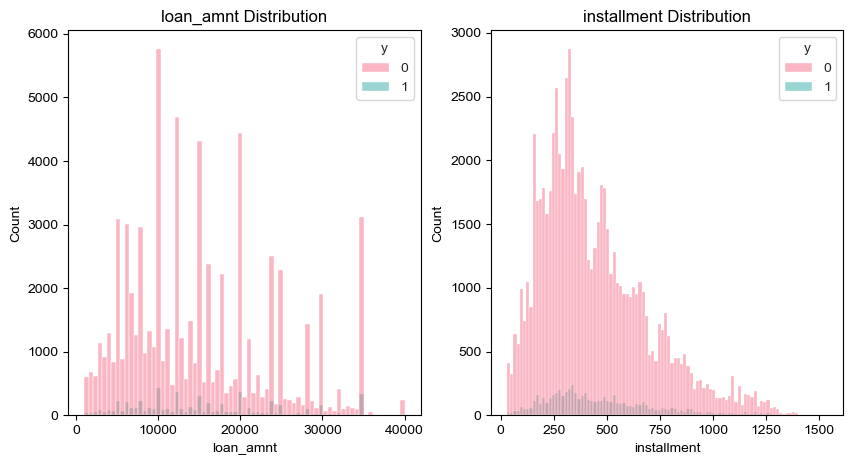

In [32]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.set_style('whitegrid')
plt.subplot(1,2,1)
sns.histplot(x='loan_amnt',hue= 'y', data=raw, palette = 'husl')
plt.title('loan_amnt Distribution')

plt.subplot(1,2,2)
sns.histplot(x='installment',hue= 'y', data=raw, palette = 'husl')
plt.title('installment Distribution')

Text(0.5, 1.0, 'installment Distribution')

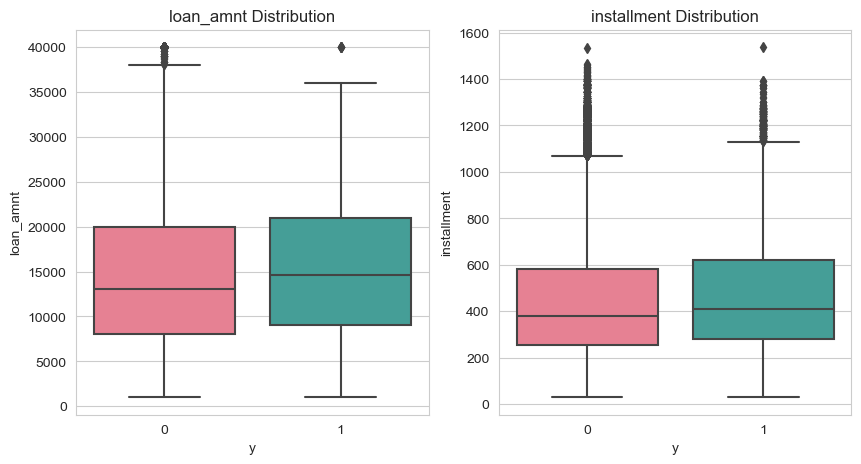

In [33]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plt.subplot(1,2,1)
sns.boxplot(x='y',y='loan_amnt', data=raw, palette = 'husl')
plt.title('loan_amnt Distribution')

plt.subplot(1,2,2)
sns.boxplot(x='y',y='installment', data=raw, palette = 'husl')
plt.title('installment Distribution')

In [34]:
raw.groupby(by='y')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,73963.0,14992.592580,8722.523398,1000.0,8000.0,13050.0,20000.0,40000.0
1,6037.0,15830.110154,8775.747889,1000.0,9050.0,14575.0,21000.0,40000.0


In [35]:
raw.groupby(by='y')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,73963.0,441.186301,254.842241,30.12,256.23,379.76,581.58,1535.71
1,6037.0,473.107543,264.143771,30.54,279.74,408.22,620.49,1536.95


### Annual Income

Text(0.5, 1.0, 'Annual Income Distribution (<= 337250/year)')

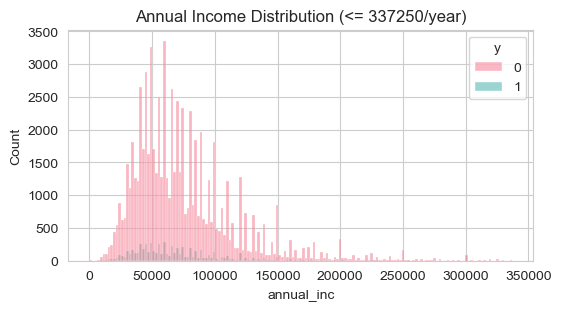

In [36]:
fig, ax = plt.subplots(figsize=(6,3))
sns.set_style('whitegrid')
sns.histplot(x='annual_inc', hue='y', data=raw[(raw.annual_inc <= 337250)], palette='husl')
plt.title('Annual Income Distribution (<= 337250/year)')

In [37]:
print((raw[raw.annual_inc >= 337250].shape[0] / raw.shape[0]) * 100)

0.49


In [38]:
raw.loc[raw.annual_inc >= 337250, 'y'].value_counts()

0    368
1     24
Name: y, dtype: int64

### dti

Text(0.5, 1.0, 'dti Distribution (<= 205)')

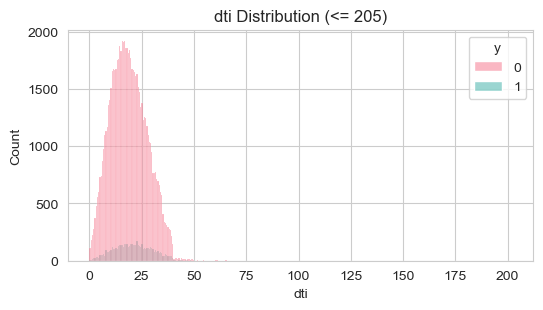

In [39]:
fig, ax = plt.subplots(figsize=(6,3))
sns.set_style('whitegrid')
sns.histplot(x='dti', hue='y', data=raw[(raw.dti <= 205)], palette='husl')
plt.title('dti Distribution (<= 205)')

In [40]:
print((raw[raw.dti > 205].shape[0] / raw.shape[0]) * 100)

0.01


In [41]:
raw.loc[raw.dti > 205, 'y'].value_counts()

0    7
1    1
Name: y, dtype: int64

### delinq_amnt', 'delinq_2yrs',
'mths_since_last_delinq',
'mths_since_last_record',
'inq_last_12m'

Text(0.5, 1.0, 'delinq_amnt Distribution')

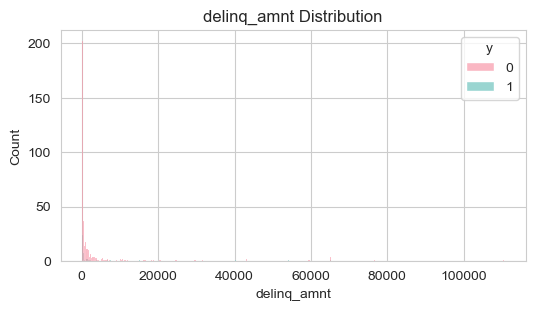

In [42]:
fig, ax = plt.subplots(figsize=(6,3))
sns.histplot(x='delinq_amnt', hue='y', data=raw[(raw.delinq_amnt != 0)], palette='husl')
plt.title('delinq_amnt Distribution')

In [43]:
print((raw[raw.delinq_amnt != 0].shape[0] / raw.shape[0]) * 100)

0.505


In [44]:
raw.loc[raw.delinq_amnt == 0, 'y'].value_counts()

0    73604
1     5992
Name: y, dtype: int64

In [45]:
raw.loc[raw.delinq_amnt != 0, 'y'].value_counts()

0    359
1     45
Name: y, dtype: int64

Text(0.5, 1.0, 'delinq_2yrs Distribution')

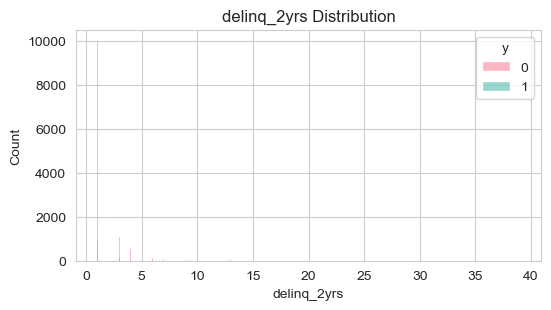

In [46]:
fig, ax = plt.subplots(figsize=(6,3))
sns.histplot(x='delinq_2yrs', hue='y', data=raw[(raw.delinq_2yrs != 0)], palette='husl')
plt.title('delinq_2yrs Distribution')

In [47]:
raw.loc[raw.delinq_2yrs == 0, 'y'].value_counts()

0    58650
1     4655
Name: y, dtype: int64

In [48]:
raw.loc[raw.delinq_2yrs != 0, 'y'].value_counts()

0    15313
1     1382
Name: y, dtype: int64

### mths_since_last_delinq

Text(0.5, 1.0, 'mths_since_last_delinq Distribution')

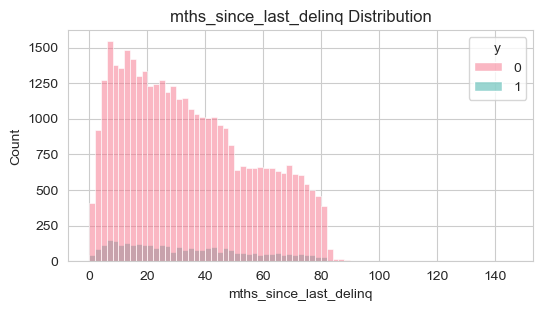

In [49]:
fig, ax = plt.subplots(figsize=(6,3))
sns.histplot(x='mths_since_last_delinq', hue='y', data=raw[(raw.mths_since_last_delinq != 'nan')], palette='husl')
plt.title('mths_since_last_delinq Distribution')

In [50]:
raw.loc[raw.mths_since_last_delinq != 'nan', 'y'].value_counts()

0    73963
1     6037
Name: y, dtype: int64

In [51]:
raw['mths_since_last_delinq'].isnull().value_counts()

False    41786
True     38214
Name: mths_since_last_delinq, dtype: int64

In [52]:
raw['mths_since_last_delinq'].isnull().groupby(raw['y']).mean()

y
0    0.479510
1    0.455193
Name: mths_since_last_delinq, dtype: float64

**mths_since_last_delinq missing value is random ==> median/frequency imputation**

### mths_since_last_record

Text(0.5, 1.0, 'mths_since_last_record Distribution')

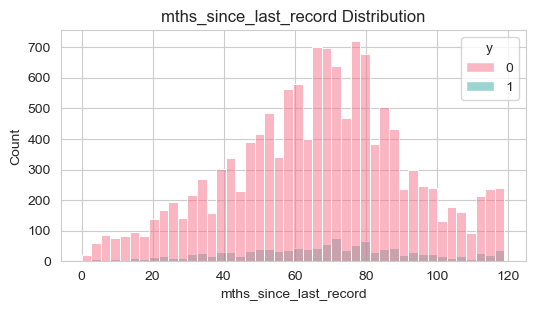

In [53]:
fig, ax = plt.subplots(figsize=(6,3))
sns.histplot(x='mths_since_last_record', hue='y', data=raw[(raw.mths_since_last_record != 'nan')], palette='husl')
plt.title('mths_since_last_record Distribution')

In [54]:
raw.loc[raw.mths_since_last_record != 'nan', 'y'].value_counts()

0    73963
1     6037
Name: y, dtype: int64

In [55]:
raw['mths_since_last_record'].isnull().value_counts()

True     65468
False    14532
Name: mths_since_last_record, dtype: int64

In [56]:
raw['mths_since_last_record'].isnull().groupby(raw['y']).mean()

y
0    0.819788
1    0.800729
Name: mths_since_last_record, dtype: float64

**mths_since_last_record missing value ===> Mean Imputation**

### inq_last_12m

Text(0.5, 1.0, 'inq_last_12m Distribution')

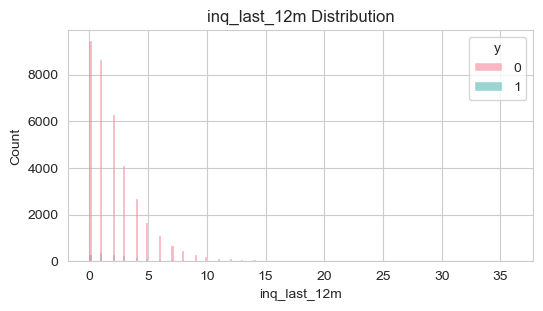

In [57]:
fig, ax = plt.subplots(figsize=(6,3))
sns.histplot(x='inq_last_12m', hue='y', data=raw[(raw.inq_last_12m != 'nan')], palette='husl')
plt.title('inq_last_12m Distribution')

In [58]:
raw.loc[raw.inq_last_12m != 'nan', 'y'].value_counts()

0    73963
1     6037
Name: y, dtype: int64

In [59]:
raw['inq_last_12m'].isnull().value_counts()

True     42605
False    37395
Name: inq_last_12m, dtype: int64

In [60]:
raw['inq_last_12m'].isnull().groupby(raw['y']).mean()

y
0    0.516326
1    0.731489
Name: inq_last_12m, dtype: float64

**inq_last_12m missing value ===> Arbitrary Imputation**

### inq_last_6mths and acc_now_delinq


<Axes: xlabel='acc_now_delinq', ylabel='count'>

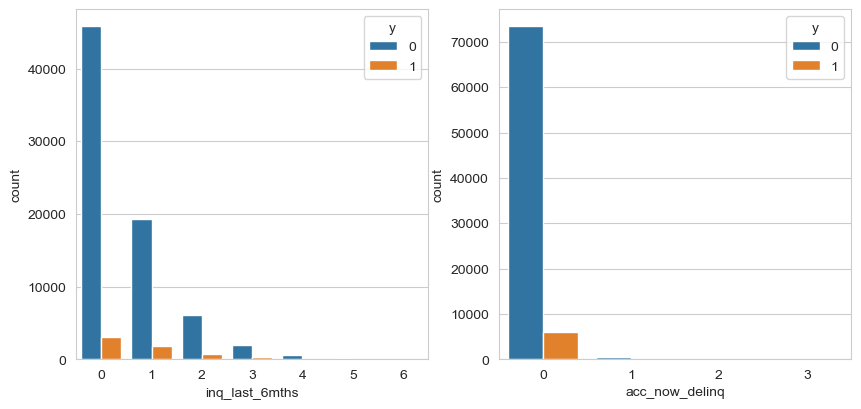

In [61]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.countplot(x='inq_last_6mths', data=raw, hue='y')

plt.subplot(2, 2, 2)
sns.countplot(x='acc_now_delinq', data=raw, hue='y')

## Categorical Variables

In [62]:
categorical

['term',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'last_credit_pull_d']

### term, home_ownership, verification_status & purpose

In [63]:
#raw['term'] = raw['term'].apply(lambda x: int(x.strip().replace(' months', '')))

In [64]:
raw.home_ownership.value_counts()

MORTGAGE    39054
RENT        31629
OWN          9316
ANY             1
Name: home_ownership, dtype: int64

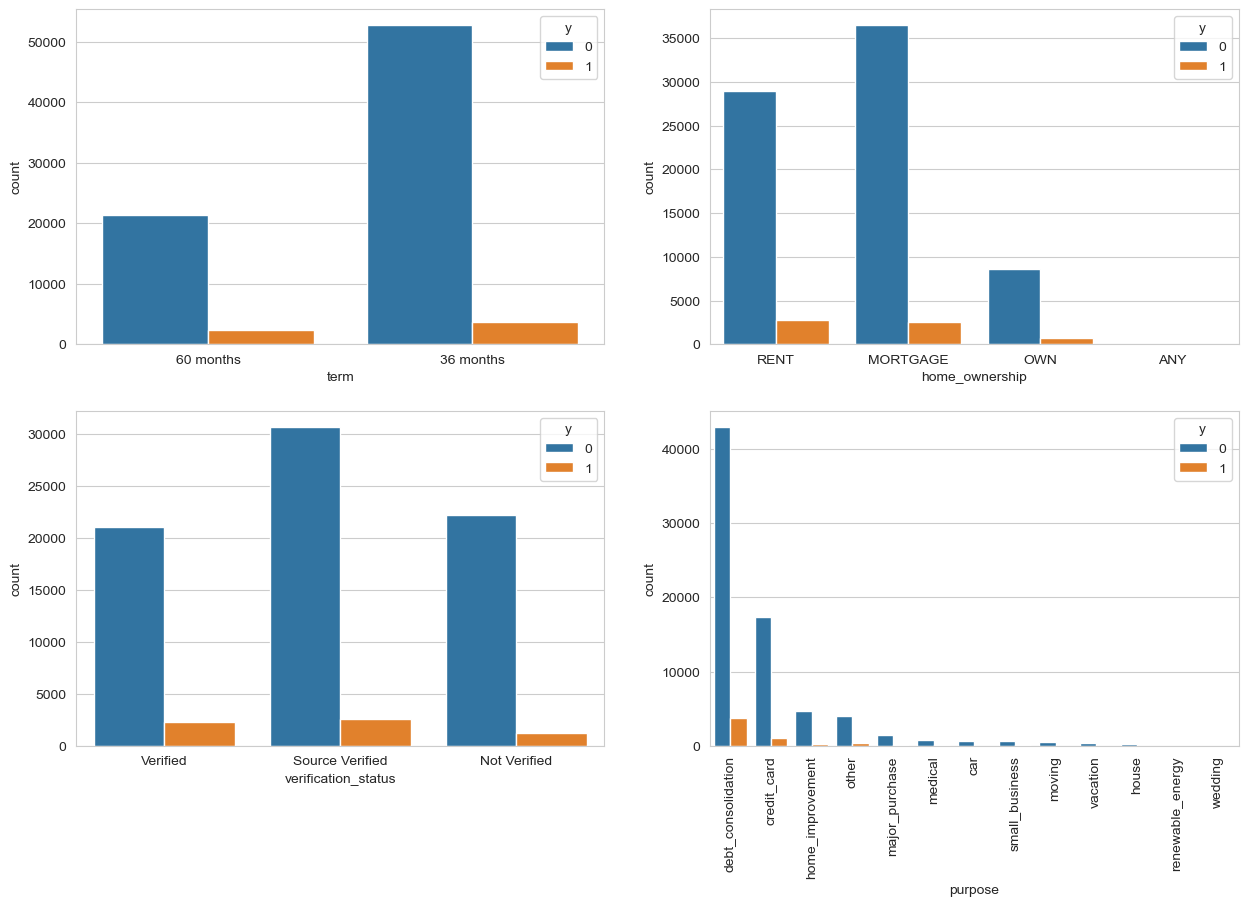

In [65]:
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='term', data=raw, hue='y')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=raw, hue='y')

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=raw, hue='y')

plt.subplot(4, 2, 4)
purpose_order = raw['purpose'].value_counts().sort_values(ascending=False).index
g = sns.countplot(x='purpose', data=raw, hue='y', order=purpose_order)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

**group the rare label for purpose**

In [66]:
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']



raw['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    
raw['region'] = raw['addr_state'].apply(finding_regions)

In [67]:
# This code will take the current date and transform it into a year-month format
raw['complete_date'] = pd.to_datetime(raw['issue_d'],format='%b-%y')

group_dates = raw.groupby(['complete_date', 'region'], as_index=False).sum()

group_dates['issue_d'] = [month.to_period('M') for 
                          month in group_dates['complete_date']]

group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates['loan_amnt'] = group_dates['loan_amnt']/1000


df_dates = pd.DataFrame(data=group_dates[['issue_d','region','loan_amnt']])

C:\Users\xzhu5\AppData\Local\Temp\ipykernel_23652\286783799.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\xzhu5\AppData\Local\Temp\ipykernel_23652\286783799.py:9: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Text(0.5, 1.0, 'Loans issued by Region')

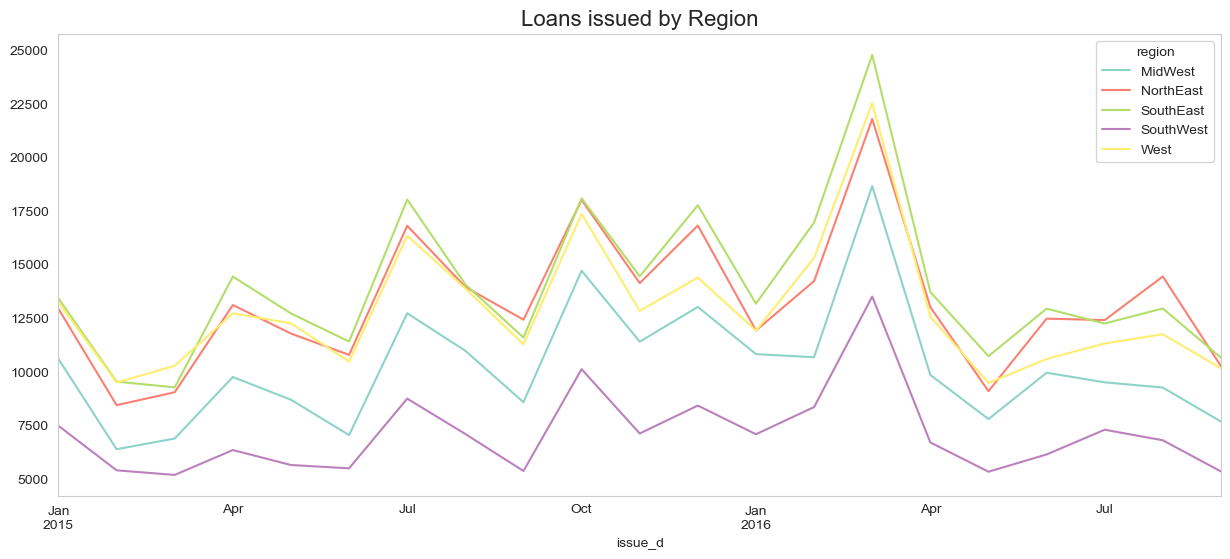

In [68]:
#plt.style.use('dark_background')
cmap = plt.cm.Set3

by_issued_amount = df_dates.groupby(['issue_d', 'region']).loan_amnt.sum()
by_issued_amount.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=True, figsize=(15,6))

plt.title('Loans issued by Region', fontsize=16)

<Axes: xlabel='region', ylabel='count'>

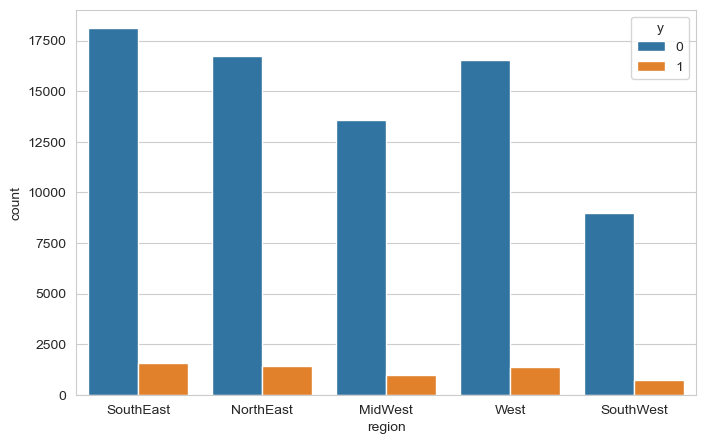

In [69]:
plt.figure(figsize=(8, 5))

sns.countplot(x='region', data=raw, hue='y')

In [70]:
def emp_length_to_int(emp_length):
    if isinstance(emp_length, str):
        emp_length_str = emp_length.strip()
        if emp_length == '< 1 year':
            return 0
        elif emp_length == '10+ years':
            return 10
        else:
            return int(emp_length.split()[0])
    else:
        return np.nan


In [71]:
new = raw.copy()
new['emp_length_int'] = new['emp_length'].apply(emp_length_to_int)

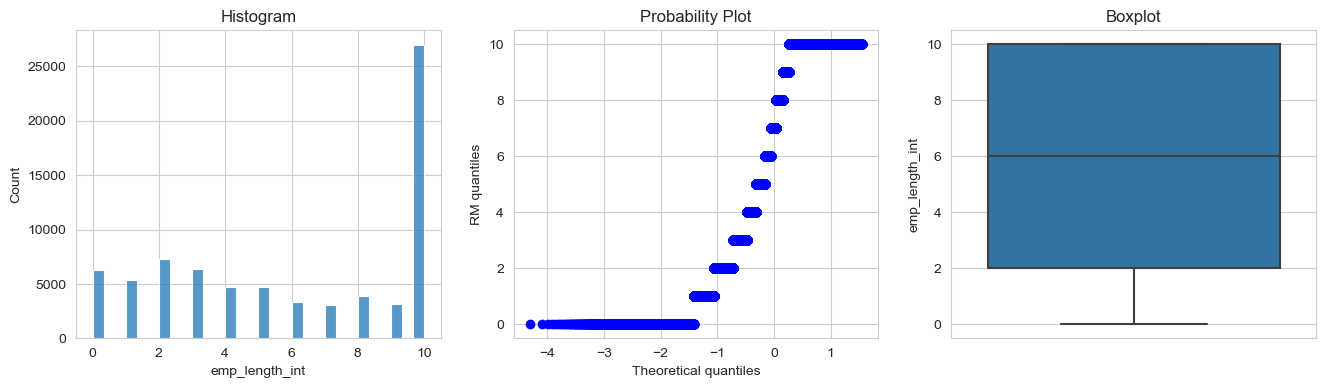

In [72]:
diagnostic_plots(new, 'emp_length_int')

In [73]:
# do not have these info at the time of application
#raw.drop(['issue_d'], axis=1, inplace=True)

In [74]:
new['earliest_cr_line'] = pd.to_datetime(new['earliest_cr_line'], 
                                         format='%b-%y')

new['last_credit_pull_d'] = pd.to_datetime(new['last_credit_pull_d'], 
                                           format='%b-%y')

new['months_passed'] = (new['last_credit_pull_d'] -new['earliest_cr_line']) / np.timedelta64(1, 'M')
new['months_passed'] = np.round(new['months_passed'],0)

new[['earliest_cr_line', 'last_credit_pull_d','months_passed','issue_d']].head()

,earliest_cr_line,last_credit_pull_d,months_passed,issue_d
0,1976-01-01,2016-12-01,491.0,Sep-16
1,1995-01-01,2016-12-01,263.0,Apr-16
2,1998-08-01,2016-12-01,220.0,Jan-16
3,1996-10-01,2016-10-01,240.0,Jul-15
4,2000-11-01,2016-12-01,193.0,Feb-16


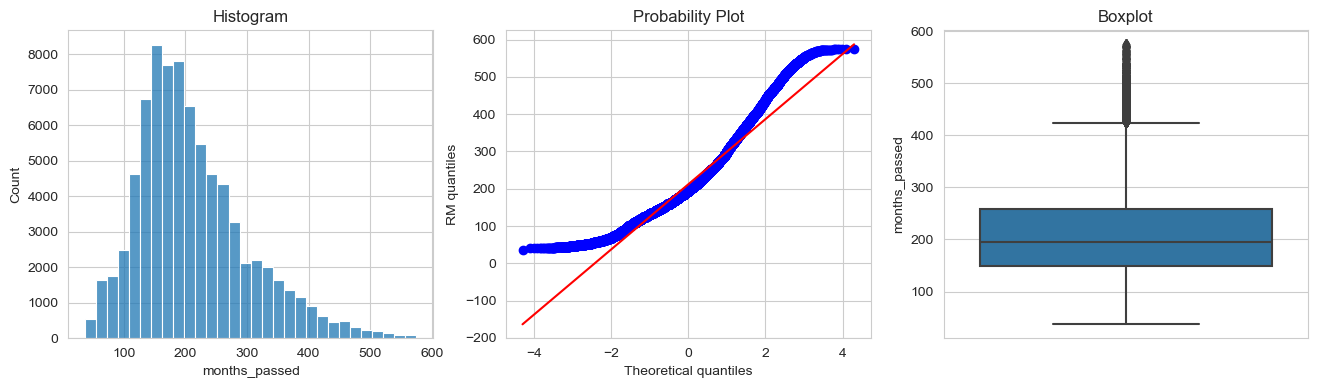

In [75]:
diagnostic_plots(new[(new.months_passed > 0)], 'months_passed')

In [76]:
new['months_passed'].min(), new['months_passed'].max()

(-635.0, 575.0)

In [77]:
upper_boundary, lower_boundary = find_normal_boundaries(new, 'months_passed')
upper_boundary, lower_boundary

(503.5551411344032, -83.65614618465571)

In [78]:
new['months_passed'].isnull().value_counts()

False    79996
True         4
Name: months_passed, dtype: int64

**month_passed has outlier and missing value**

<a id='EDA'></a>
<h1 style="background-color:#fbcc54;font-family:monospace;font-size:200%;text-align:center">5. Final dataset </h1>

In [98]:
class Transformer(object):
    
    def fit(self, X, y=None): 
        pass
        
        
    def transform(self, X, y=None): 
        df = pd.DataFrame()
        df['id'] =X.id
        df['region'] = X.addr_state.map(self.finding_regions)  
        df['emp_length_int'] = X.emp_length.map(self.emp_length_to_int)
        df['y'] = X.loan_status.apply(lambda x: 0 if x in ['Current', 'Fully Paid'] else 1)
        df['last_fico_average'] = (X['last_fico_range_low'] + X['last_fico_range_high']) / 2
        df['fico_average'] = (X['fico_range_low'] + X['fico_range_high']) / 2
        df['earliest_cr_line_dt'] = pd.to_datetime(X['earliest_cr_line'], 
                                         format='%b-%y')
        df['last_credit_pull_d_dt'] = pd.to_datetime(X['last_credit_pull_d'], 
                                           format='%b-%y')
        df['credic_history'] = (df['last_credit_pull_d_dt'] -df['earliest_cr_line_dt']) / np.timedelta64(1, 'M')
        df['credic_history'] = np.round(df['credic_history'],0)
        return df
    
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def finding_regions(self, X, y=None):
        west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
        south_west = ['AZ', 'TX', 'NM', 'OK']
        south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
        mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
        north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']
        if X in west:
            return 'West'
        elif X in south_west:
            return 'SouthWest'
        elif X in south_east:
            return 'SouthEast'
        elif X in mid_west:
            return 'MidWest'
        elif X in north_east:
            return 'NorthEast'
        
    def emp_length_to_int(self, X, y=None):
        if isinstance(X, str):
            emp_length_str = X.strip()
            if X == '< 1 year':
                return 0
            elif X == '10+ years':
                return 10
            else:
                return int(X.split()[0])
        else:
            return np.nan

In [99]:
class DataProcessor(Transformer):
    
    def __init__(self):
        pass
    
    def read(self, file_path):
        # Read in the raw data from a CSV file
        ori = pd.read_csv(file_path)
        
        # Perform data transformations here using the `raw` dataframe
        dtf = Transformer()
        transformed = dtf.fit_transform(ori)
        return transformed
    
    def merge_data(self, transformed, raw):
        # Merge the transformed data with the original raw data
        merged = transformed.merge(ori, how='left', on='id')
        
        # Drop columns we don't need from the merged data
        merged.drop(['loan_status', 'id', 'issue_d', 'last_fico_range_low', 'last_fico_range_high', 'fico_range_low',
                     'fico_range_high', 'addr_state', 'emp_length', 'last_credit_pull_d', 'earliest_cr_line',
                     'earliest_cr_line_dt', 'last_credit_pull_d_dt'], axis=1, inplace=True)
        
        return merged

In [100]:
ori = pd.read_csv('Data.csv')
processor = DataProcessor()
transformed = processor.read('Data.csv')

In [103]:
# Use the `merge_data` method to merge the transformed data with the raw data
df = processor.merge_data(transformed, ori)

# View the resulting dataframe
df.head()

,region,emp_length_int,y,last_fico_average,fico_average,credic_history,loan_amnt,term,installment,home_ownership,...,verification_status,purpose,dti,acc_now_delinq,delinq_amnt,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,inq_last_6mths,inq_last_12m
0,SouthEast,6.0,0,707.0,692.0,491.0,30000,60 months,761.64,RENT,...,Verified,debt_consolidation,27.42,0,0,0,26.0,NaN,0,0.0
1,NorthEast,10.0,0,647.0,672.0,263.0,30000,60 months,692.93,MORTGAGE,...,Source Verified,home_improvement,7.50,0,0,1,16.0,NaN,1,3.0
2,SouthEast,6.0,0,737.0,737.0,220.0,16000,60 months,379.39,RENT,...,Not Verified,debt_consolidation,27.87,0,0,0,80.0,NaN,0,2.0
3,SouthEast,5.0,0,747.0,727.0,240.0,14000,36 months,439.88,RENT,...,Source Verified,debt_consolidation,21.65,0,0,0,NaN,42.0,0,NaN
4,MidWest,3.0,0,707.0,662.0,193.0,7500,36 months,252.67,MORTGAGE,...,Not Verified,debt_consolidation,29.09,0,0,0,NaN,NaN,2,5.0


### Types of variables

In [104]:
df.dtypes

region                     object
emp_length_int            float64
y                           int64
last_fico_average         float64
fico_average              float64
credic_history            float64
loan_amnt                   int64
term                       object
installment               float64
home_ownership             object
annual_inc                float64
verification_status        object
purpose                    object
dti                       float64
acc_now_delinq              int64
delinq_amnt                 int64
delinq_2yrs                 int64
mths_since_last_delinq    float64
mths_since_last_record    float64
inq_last_6mths              int64
inq_last_12m              float64
dtype: object